# Model: GRU (Gated Recurrent Unit)  - Stock Token: FPT - Test/Train/Vaildation: 80/10/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024)
- Window-slide: 10, epochs: 200, batch-size: 32
----
### Model evaluation (Test set)
- RMSE: 1244.56
- MAE: 894.87
- MAPE: 1.18 %

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 1. Data preprocessing


In [64]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [65]:
# Change stock and split to adjust between splitting type and stock
stock = 0  # FPT
split = 2  # 8 1 1

In [66]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df = df[["time", "close"]]
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)

df

,close
time,
2019-03-01,19270
2019-03-04,19440
2019-03-05,19390
2019-03-06,19270
2019-03-07,19330
...,...
2024-02-26,108000
2024-02-27,107900
2024-02-28,108500


In [67]:
df.shape

(1252, 1)

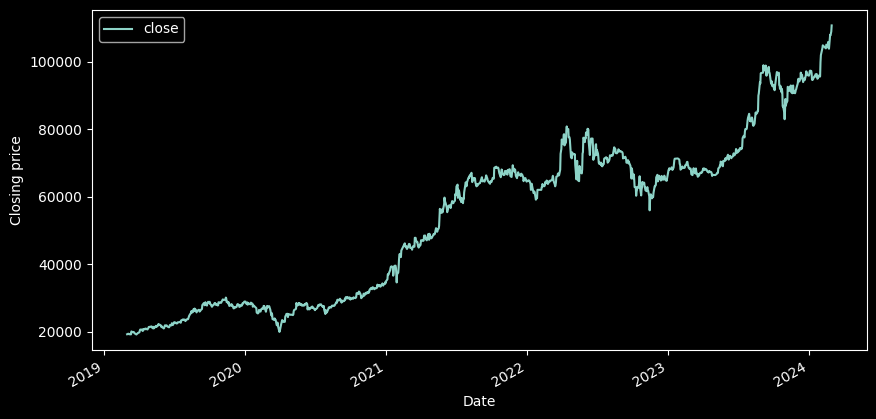

In [68]:
df.plot(figsize=(10, 5))
plt.ylabel("Closing price")
plt.xlabel("Date")
plt.show()

In [69]:
df = df.reset_index()["close"]
df

0        19270
1        19440
2        19390
3        19270
4        19330
         ...  
1247    108000
1248    107900
1249    108500
1250    109000
1251    110800
Name: close, Length: 1252, dtype: int64

In [70]:
# Normalize data between 0 and 1 because we using natural network model
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df).reshape(-1, 1))

## 2. Model training


### Create train set, test set, validation set and reshape them


In [71]:
# Defining the split size
train_size = int(split_type[split][0] * len(df_scaled))
test_size = int(split_type[split][1] * len(df_scaled))
val_size = len(df) - train_size - test_size

In [72]:
# Splitting data into train, test and validation set
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size : train_size + test_size]
val_data = df_scaled[train_size + test_size :]

In [73]:
# Function to create dataset input and output, it will convert an array of values into a dataset matrix, use the sliding window with the time_step argument
def create_dataset(data, window_side):
    X, y = [], []

    for i in range(len(data) - window_side - 1):
        X.append(data[i : (i + window_side), 0])
        y.append(data[i + window_side, 0])

    return np.array(X), np.array(y)

In [74]:
# Define time step, it mean the model will take 10 days before to predict the closing price 'at that time'
WINDOW_SIDE = 10

# Create X, y for train, test and validate
X_train, y_train = create_dataset(train_data, WINDOW_SIDE)
X_test, y_test = create_dataset(test_data, WINDOW_SIDE)
X_val, y_val = create_dataset(val_data, WINDOW_SIDE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((990, 10), (990,), (114, 10), (114,), (115, 10), (115,))

In [75]:
# Reshape the dataset to suit the RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

### Start train model


In [76]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Input

# Initialize LSTM model
model = Sequential(
    [
        Input((X_train.shape[1], 1)),
        GRU(100),
        Dense(32, activation="relu"),
        Dense(1),  # activation default is linear
    ]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 10, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,885 (253.46 KB)

 Trainable params: 64,885 (253.46 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(optimizer="adam", loss="mse", metrics=["mean_absolute_error"])

In [78]:
EPOCHS = 200
BATCH_SIZE = 32
VERBOSE = 1

# Train the model
model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
)

Epoch 1/200


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0439 - mean_absolute_error: 0.1486 - val_loss: 2.4293e-04 - val_mean_absolute_error: 0.0132
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5860e-04 - mean_absolute_error: 0.0166 - val_loss: 7.9844e-04 - val_mean_absolute_error: 0.0239
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6966e-04 - mean_absolute_error: 0.0109 - val_loss: 2.0304e-04 - val_mean_absolute_error: 0.0101
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4167e-04 - mean_absolute_error: 0.0103 - val_loss: 3.2541e-04 - val_mean_absolute_error: 0.0129
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0444e-04 - mean_absolute_error: 0.0094 - val_loss: 3.3029e-04 - val_mean_absolute_error: 0.0131
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5529e-04 - mean_absolute_error: 0.0105 - val_loss: 2.0652e-04 - val_mean_absolute_error: 0.0100
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8990e-04 - m

### Predicting with test set and validate set


In [79]:
# Predict and convert the data back - because i reshaped between 0 and 1, so need to convert back
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

y_pred_val = model.predict(X_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## 3. Model evaluation


In [80]:
# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3402e-05 - mean_absolute_error: 0.0061 
Test Loss: [7.863371865823865e-05, 0.006390776019543409]


In [81]:
# Splitting data into train, test and validation set again to evaluate, because i shaped the data between 0 and 1 to suit the model
train_data1 = df[:train_size]
test_data1 = df[train_size : train_size + test_size]
val_data1 = df[train_size + test_size :]

X_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

X_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [82]:
print(len(y_test))
print(len(y_test1))

114
125


In [83]:
# Evaluation
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
    mean_absolute_error as mae,
)


def evalute_model(y, y_pred):
    # Because i use the sliding window with the time_step value, so the length of 'y' and 'y predict' will difference
    min_len = min(len(y), len(y_pred))
    y = y[-min_len:]
    y_pred = y_pred[-min_len:]

    print(f"MSE: {mse(y, y_pred)}")
    print(f"RMSE: {np.sqrt(mse(y, y_pred))}")
    print(f"MAE: {mae(y, y_pred)}")
    print(f"MAPE: {mape(y, y_pred) * 100} %")

In [84]:
# So the result will change every time RUN ALL (build model again), because the model will take random start number.
# But it dont change much, the MAPE will less than 2 %(test set)
# Model evaluation on test set
print("Model evalution on test set")
evalute_model(y_test1, y_pred_test)

print("")
# Model evaluation on validate set
print("Model evalution on validate set")
evalute_model(y_val1, y_pred_val)

Model evalution on test set
MSE: 1548936.661401046
RMSE: 1244.5628394745868
MAE: 894.8750685307018
MAPE: 1.176772413693427 %

Model evalution on validate set
MSE: 4554911.473187521
RMSE: 2134.223857327886
MAE: 1589.7862092391304
MAPE: 1.6569360742655834 %


## 4. Predict the next 30/60/90 days


In [85]:
def forecast(data, window_side, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-window_side:]
    y_forecast = []

    for i in range(forecast_days + 1):
        # Reshape x_forecast to have the shape (1, window_side, num_features)
        x_forecast_reshaped = x_forecast.reshape(1, window_side, x_forecast.shape[1])
        # Predict the next day
        y = model.predict(x_forecast_reshaped)
        y_forecast.append(y[0][0])

        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]

    return y_forecast

In [86]:
y_pred_30_days = forecast(val_data, 5, 30)

# Assuming y_pred_30_days is a 1D array
y_pred_30_days = np.array(y_pred_30_days).reshape(-1, 1)

# Inverse transform y_pred_30_days
y_pred_30_days = scaler.inverse_transform(y_pred_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

In [87]:
y_pred_30_days

array([[109587.03 ],
       [109426.71 ],
       [109590.83 ],
       [109481.99 ],
       [109566.53 ],
       [109505.84 ],
       [109550.81 ],
       [109517.86 ],
       [109542.086],
       [109524.29 ],
       [109537.375],
       [109527.76 ],
       [109534.83 ],
       [109529.65 ],
       [109533.45 ],
       [109530.64 ],
       [109532.71 ],
       [109531.2  ],
       [109532.31 ],
       [109531.5  ],
       [109532.086],
       [109531.66 ],
       [109531.984],
       [109531.734],
       [109531.92 ],
       [109531.78 ],
       [109531.875],
       [109531.805],
       [109531.86 ],
       [109531.81 ],
       [109531.86 ]], dtype=float32)

### Continute predict the next 60/90 days


In [88]:
y_pred_60_days = forecast(val_data, 5, 60)
y_pred_60_days = np.array(y_pred_60_days).reshape(-1, 1)
y_pred_60_days = scaler.inverse_transform(y_pred_60_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [89]:
y_pred_90_days = forecast(val_data, 5, 90)
y_pred_90_days = np.array(y_pred_90_days).reshape(-1, 1)
y_pred_90_days = scaler.inverse_transform(y_pred_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

### Plot the data


In [90]:
def draw_plot(y_days_predict, days):
    plt.figure(figsize=(10, 6))
    plt.ylabel("Closing Price")

    # Raw data
    plt.plot(train_data1.index, train_data1, label="Train")
    plt.plot(test_data1.index, test_data1, label="Test")
    plt.plot(val_data1.index, val_data1, label="Validate")

    # Predict test and validate
    plt.plot(
        test_data1.index[
            WINDOW_SIDE : len(y_pred_test) + WINDOW_SIDE
        ],  # because using the sliding window (WINDOW_SIDE) -> the index of 2 dataset is difference
        y_pred_test,
        label="Predicted Test",
        linestyle="--",
    )
    plt.plot(
        val_data1.index[WINDOW_SIDE : len(y_pred_val) + WINDOW_SIDE],
        y_pred_val,
        label="Predicted Validate",
        linestyle="--",
    )

    # Predict the next 30/60/90 days
    plt.plot(
        val_data1.index[-1] + np.arange(1, len(y_days_predict) + 1),
        y_days_predict,
        label=f"Predicted Next {days} Days",
        linestyle="--",
    )

    plt.title(f"{stock_name[stock]} Stock Closing Price Prediction Using GRU")
    plt.legend()
    plt.show()

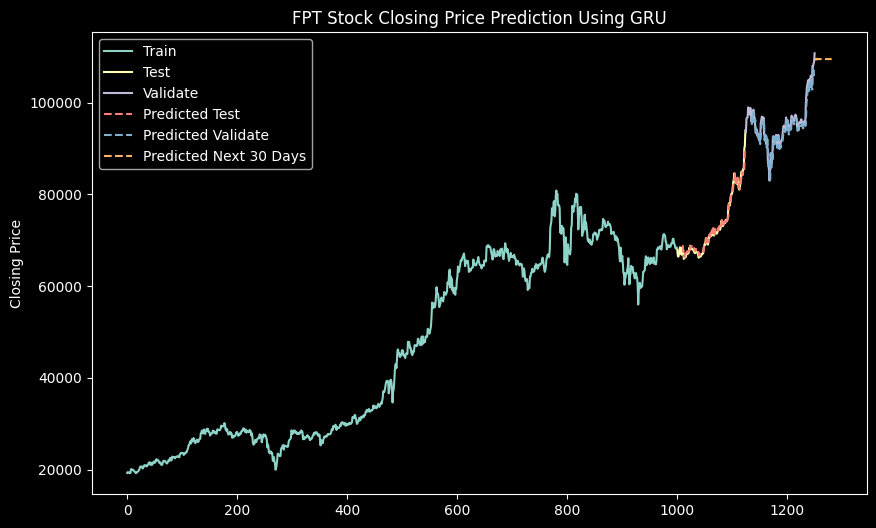

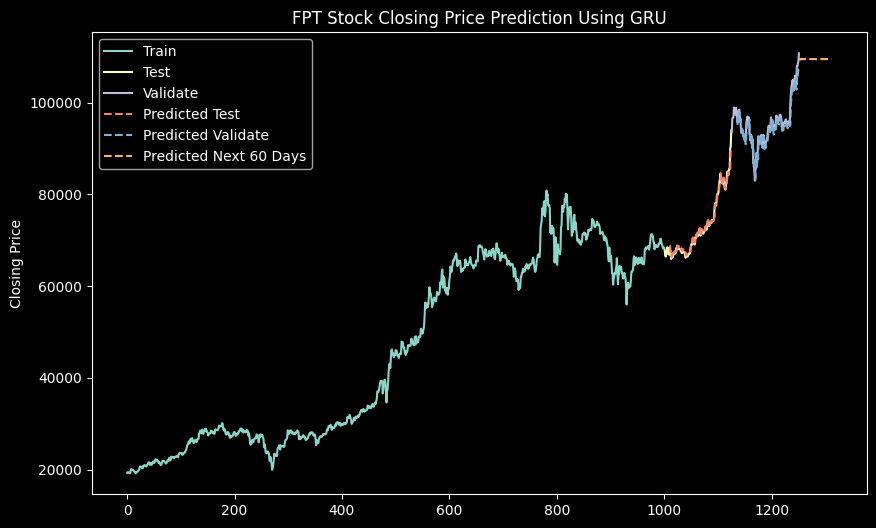

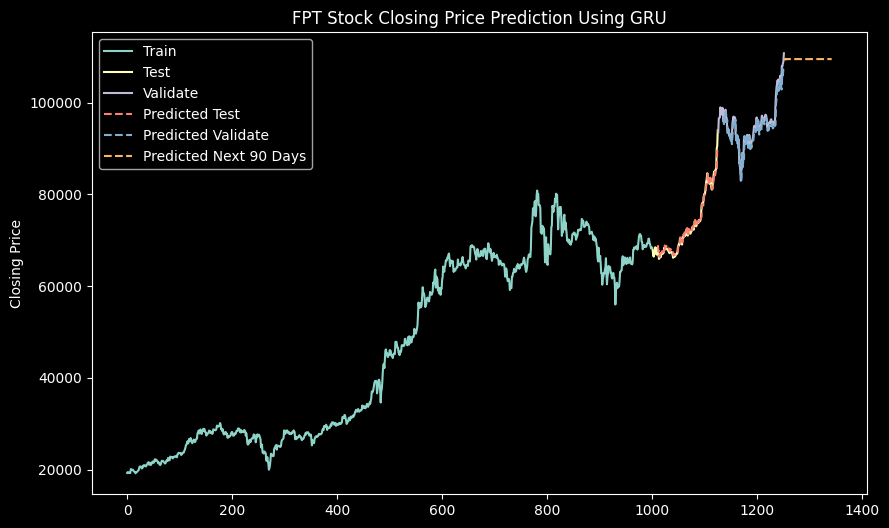

In [91]:
draw_plot(y_pred_30_days, 30)
draw_plot(y_pred_60_days, 60)
draw_plot(y_pred_90_days, 90)